# Lecture 19: Architecture

In [ ]:
GPT_CONFIG_124M = {
  "vocab_size": 50257,
  "context_length": 1024,
  "emb_dim": 768,
  "n_heads": 12,
  "n_layers": 12,
  "drop_rate": 0.1,
  "qkv_bias": False
}

In [ ]:
import torch
import torch.nn as nn

class DummyGPTModel(nn.Module):

  def __init__(self, cfg):
    super().__init__()
    self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
    self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
    self.drop_emb = nn.Dropout(cfg["drop_rate"])

    self.transformer_blocks = nn.Sequential(
      *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])]
    )

    self.final_norm = DummyLayerNorm(cfg["emb_dim"])

    self.out_head = nn.Linear(
      cfg["emb_dim"], cfg["vocab_size"], bias=False
    )


  def forward(self, in_idx):
    batch_size, seq_len = in_idx.shape
    tok_embeds = self.tok_emb(in_idx)
    # Look up the learned positional embedding for each position 0…seq_len−1 on the same device as the input.
    pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
    x = tok_embeds + pos_embeds
    x = self.drop_emb(x)
    x = self.transformer_blocks(x)
    x = self.final_norm(x)

    logits = self.out_head(x)
    return logits


class DummyTransformerBlock(nn.Module):
  def __init__(self, cfg):
    super().__init__()

  def forward(self, x):
    return x

class DummyLayerNorm(nn.Module):
  def __init__(self, cfg):
    super().__init__()

  def forward(self, x):
    return x


## Step 1: Tokenization

In [12]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
batch = []

txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))

batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


## Step 2: Initialize GPT Model

In [19]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print("output shape:", logits.shape)
print(logits)

output shape: torch.Size([2, 4, 50257])
tensor([[[-1.2034,  0.3201, -0.7130,  ..., -1.5548, -0.2390, -0.4667],
         [-0.1192,  0.4539, -0.4432,  ...,  0.2392,  1.3469,  1.2430],
         [ 0.5307,  1.6720, -0.4695,  ...,  1.1966,  0.0111,  0.5835],
         [ 0.0139,  1.6754, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[-1.0908,  0.1798, -0.9484,  ..., -1.6047,  0.2439, -0.4530],
         [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
         [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
         [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
       grad_fn=<UnsafeViewBackward0>)


> 2 text samples

> each sample has 4 tokens

> each token has dimension 50257

# Lecture 20: LayerNorm

In [21]:
torch.manual_seed(123)
batch_example = torch.randn(2,5)
layer = nn.Sequential(nn.Linear(5,6), nn.ReLU())
out = layer(batch_example)
out

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)

keep_dim=True tells PyTorch to retain the reduced dimension with size 1, instead of just removing it

So this means we go from (B, T, D) to (B, T, 1)

Without this, we get (B, T)

We want (B, T, 1) because we will broadcast mean and variance over the original tensor again.

In [29]:
mean = torch.mean(out, dim=-1, keepdim=True)
var = torch.var(out, dim=-1, keepdim=True)
print(mean)
print(var)

tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


In [38]:
normalized_out = (out - mean) / torch.sqrt(var)
print(normalized_out)
print(normalized_out.mean(dim=-1, keepdim=True))
print(normalized_out.var(dim=-1, keepdim=True))

tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
tensor([[-5.9605e-08],
        [ 1.9868e-08]], grad_fn=<MeanBackward1>)
tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [40]:
# Turn scientific mode off to just get 0, 1
torch.set_printoptions(sci_mode=False)
print(normalized_out.mean(dim=-1, keepdim=True))
print(normalized_out.var(dim=-1, keepdim=True))

tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [41]:
class LayerNorm(nn.Module):
  def __init__(self, emb_dim):
    super().__init__()
    self.eps = 1e-5
    self.scale = nn.Parameter(torch.ones(emb_dim))
    self.shift = nn.Parameter(torch.zeros(emb_dim))

  def forward(self, x):
    mean = x.mean(dim=-1, keepdim=True)
    var = x.var(dim=-1, keepdim=True, unbiased=False)
    norm_x = (x - mean) / torch.sqrt(var + self.eps)
    return self.scale * norm_x + self.shift

## What are scale and shift?

Two trainable parameters with same dimension as the embeddings to help the model learn how to leverage layer normalization best. This improves the model's performance on the training task.

## Why unbiased=False?

If unbiased=True, this applied Bessel's correction which uses $n-1$ rather than $n$ as the denominator for variance.

In [44]:
batch_example

tensor([[-0.1115,  0.1204, -0.3696, -0.2404, -1.1969],
        [ 0.2093, -0.9724, -0.7550,  0.3239, -0.1085]])

In [43]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


# Lecture 21: GELU Activation + Feed-Forward

In [46]:
class GELU(nn.Module):
  def __init__(self):
    super().__init__()

  # use the approximation
  def forward(self, x):
    return 0.5 * x * (1 + torch.tanh(
      torch.sqrt(torch.tensor(2.0 / torch.pi)) *
      (x + 0.044715 * torch.pow(x, 3))
    ))

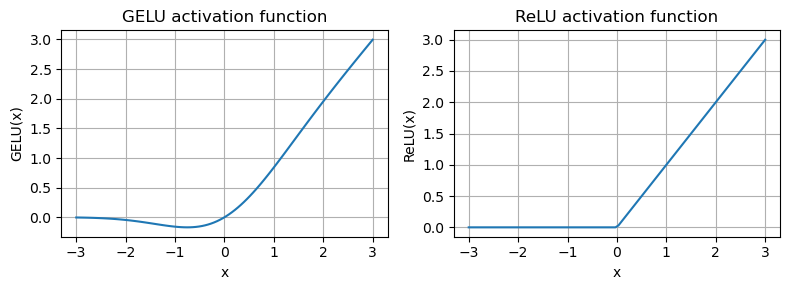

In [48]:
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()

x = torch.linspace(-3, 3, 100)
y_gelu = gelu(x)
y_relu = relu(x)

plt.figure(figsize=(8,3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
  plt.subplot(1,2,i)
  plt.plot(x,y)
  plt.title(f"{label} activation function")
  plt.xlabel("x")
  plt.ylabel(f"{label}(x)")
  plt.grid(True)

plt.tight_layout()
plt.show()

In [55]:
class FeedForward(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
      GELU(),
      nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"])
    )

  def forward(self, x):
    # use sequential for cleaner code
    return self.layers(x)


In [56]:
print(GPT_CONFIG_124M["emb_dim"])

768


In [57]:
ff = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2,3,768)
out = ff(x)
print(out.shape)

torch.Size([2, 3, 768])


# Lecture 22: Shortcut Connections

In [73]:
class ExampleDeepNN(nn.Module):
  def __init__(self, layer_sizes, use_shortcut):
    super().__init__()
    self.use_shortcut = use_shortcut
    self.layers = nn.ModuleList([
      nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
      nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
      nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
      nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
      nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
    ])

  def forward(self, x):
    for layer in self.layers:
      layer_output = layer(x)

      if self.use_shortcut and x.shape == layer_output.shape:
        x =  x + layer_output
      else:
        x = layer_output

    return x

In [80]:
def print_gradients(model, x):
  output = model(x)
  target = torch.tensor([[0.]])

  loss = nn.MSELoss()
  loss = loss(output, target)

  loss.backward()

  for name, param in model.named_parameters():
    if 'weight' in name:
      print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

In [82]:
sample_input = torch.tensor([[1., 0., -1.]])
torch.manual_seed(123)
layer_sizes = [3,3,3,3,3,1]
model_without_shortcut = ExampleDeepNN(layer_sizes, False)

In [83]:
model_without_shortcut(sample_input)

tensor([[0.0610]], grad_fn=<MulBackward0>)

In [84]:
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173587836325169
layers.1.0.weight has gradient mean of 0.00012011159560643137
layers.2.0.weight has gradient mean of 0.0007152039906941354
layers.3.0.weight has gradient mean of 0.0013988736318424344
layers.4.0.weight has gradient mean of 0.005049645435065031


__The gradients are lowwwwww... almost 0__

__See if this changes with skip connections__

In [87]:
sample_input = torch.tensor([[1., 0., -1.]])
torch.manual_seed(123)
layer_sizes = [3,3,3,3,3,1]
model_with_shortcut = ExampleDeepNN(layer_sizes, True)

__Shortcut connections prevent vanishing gradients!!__

In [88]:
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169792652130127
layers.1.0.weight has gradient mean of 0.20694106817245483
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732204914093
layers.4.0.weight has gradient mean of 1.3258540630340576


# Lecture 23: Entire Transformer Block!

In [ ]:
class LayerNorm(nn.Module):
  def __init__(self, emb_dim):
    super().__init__()
    self.eps = 1e-5
    self.scale = nn.Parameter(torch.ones(emb_dim))
    self.shift = nn.Parameter(torch.zeros(emb_dim))

  def forward(self, x):
    mean = x.mean(dim=-1, keepdim=True)
    var = x.var(dim=-1, keepdim=True, unbiased=False)
    norm_x = (x - mean) / torch.sqrt(var + self.eps)
    return self.scale * norm_x + self.shift

class GELU(nn.Module):
  def __init__(self):
    super().__init__()

  # use the approximation
  def forward(self, x):
    return 0.5 * x * (1 + torch.tanh(
      torch.sqrt(torch.tensor(2.0 / torch.pi)) *
      (x + 0.044715 * torch.pow(x, 3))
    ))
  
class FeedForward(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
      GELU(),
      nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"])
    )

  def forward(self, x):
    # use sequential for cleaner code
    return self.layers(x)

In [90]:
class MultiHeadAttention(torch.nn.Module):
  def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
    super().__init__()
    assert (d_out % num_heads == 0), \
      "d_out must be divisible by num_heads"
    self.d_out = d_out
    self.num_heads = num_heads
    self.head_dim = d_out // num_heads

    self.W_q = torch.nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_k = torch.nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_v = torch.nn.Linear(d_in, d_out, bias=qkv_bias)
    self.out_proj = torch.nn.Linear(d_out, d_out) # linear layer to combine head outputs
    self.dropout = torch.nn.Dropout(dropout)
    neg_inf_matrix = torch.full((context_length, context_length), float('-inf'))
    self.mask = torch.triu(neg_inf_matrix, diagonal=1)

  def forward(self, x):
    b, num_tokens, d_out = x.shape
    keys = self.W_k(x)
    values = self.W_v(x)
    queries = self.W_q(x)

    # unwrap the last dimension to 4D tensors
    keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
    values = values.view(b, num_tokens, self.num_heads, self.head_dim)
    queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

    # transpose from (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
    # want to group by heads instead of tokens
    keys = keys.transpose(1,2)
    values = values.transpose(1,2)
    queries = queries.transpose(1,2)

    attn_scores = queries @ keys.transpose(2,3) # (B, H, Lk, D) -> (B, H, D, Lk)
    # multiply (B, H, num_tokens, head_dim) * (B, H, head_dim, num_tokens)
    # this results in (B, H, num_tokens, num_tokens) -- multiply last 2D
    # Matrix multiplication is applied to the last two dimensions
    # All earlier dimensions are batch dimensions

    # precompute the causal mask at the maximum supported sequence length (context_length) for efficiency and reuse, then truncate it to num_tokens so it matches the current attention matrix shape during the forward pass
    # This isn't a problem because num_tokens <= context_length must always hold. Otherwise, there is some padding.
    attn_scores_masked = attn_scores + self.mask[:num_tokens, :num_tokens]
    attn_weights = torch.softmax(attn_scores_masked / keys.shape[-1]**0.5, dim = -1)

    attn_weights = self.dropout(attn_weights)

    # multiply (B, H, num_tokens, num_tokens) by (B, H, num_tokens, head_dim)
    context_vec = (attn_weights @ values).transpose(1,2)
    # view requires their input tensors to have a contiguous memory layout and will raise a RuntimeError otherwise
    context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
    context_vec = self.out_proj(context_vec) # not really necessary
    return context_vec

In [ ]:
class FeedForward

In [95]:
GPT_CONFIG_124M = {
  "vocab_size": 50257,
  "context_length": 1024,
  "emb_dim": 768,
  "n_heads": 12,
  "n_layers": 12,
  "drop_rate": 0.1,
  "qkv_bias": False
}

class TransformerBlock(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.layer_norm_1 = LayerNorm(cfg['emb_dim'])
    self.layer_norm_2 = LayerNorm(cfg['emb_dim'])
    self.mha = MultiHeadAttention(
      cfg['emb_dim'],
      cfg['emb_dim'],
      cfg['context_length'],
      cfg['drop_rate'],
      cfg['n_heads'],
      cfg['qkv_bias']
    )
    self.dropout = nn.Dropout(cfg['drop_rate'])
    self.ff = FeedForward(cfg)

  def forward(self, x_in):
    x = self.layer_norm_1(x_in)
    x = self.mha(x)
    x = self.dropout(x)

    x = x + x_in

    x1 = self.layer_norm_2(x)
    x1 = self.ff(x1)
    x1 = self.dropout(x1)

    return x + x1

In [96]:
torch.manual_seed(123)
x = torch.rand(2, 4, 768)
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


__Notice how powerful transformers are!! The dimensions stay the same!__

# Lecture 24: Coding the entire GPT model

In [97]:
import torch
import torch.nn as nn

class GPTModel(nn.Module):

  def __init__(self, cfg):
    super().__init__()
    self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
    self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
    self.drop_emb = nn.Dropout(cfg["drop_rate"])

    self.transformer_blocks = nn.Sequential(
      *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
    )

    self.final_norm = LayerNorm(cfg["emb_dim"])

    self.out_head = nn.Linear(
      cfg["emb_dim"], cfg["vocab_size"], bias=False
    )


  def forward(self, in_idx):
    batch_size, seq_len = in_idx.shape
    tok_embeds = self.tok_emb(in_idx)
    # Look up the learned positional embedding for each position 0…seq_len−1 on the same device as the input.
    pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
    x = tok_embeds + pos_embeds
    x = self.drop_emb(x)
    x = self.transformer_blocks(x)
    x = self.final_norm(x)

    logits = self.out_head(x)
    return logits

In [ ]:
torch.manual_seed(123)
gpt_model = GPTModel(GPT_CONFIG_124M)
batch = torch.tensor([[6109, 3626, 6100, 435], [6109, 1110, 6622, 257]])
output = gpt_model(batch)

In [104]:
output.shape

torch.Size([2, 4, 50257])

In [105]:
output

tensor([[[ 0.3613,  0.4222, -0.0711,  ...,  0.3483,  0.4661, -0.2838],
         [-0.1792, -0.5660, -0.9485,  ...,  0.0477,  0.5181, -0.3168],
         [ 0.7120,  0.0332,  0.1085,  ...,  0.1018, -0.4327, -0.2553],
         [-0.9671, -0.3627,  0.6061,  ...,  0.9528, -0.5604, -0.2753]],

        [[-0.2564,  0.0900,  0.0335,  ...,  0.2659,  0.4454, -0.6806],
         [ 0.1230,  0.3653, -0.2074,  ...,  0.7705,  0.2710,  0.2246],
         [ 1.0558,  1.0318, -0.2800,  ...,  0.6936,  0.3205, -0.3178],
         [-0.1565,  0.3926,  0.3288,  ...,  1.2630, -0.1858,  0.0388]]],
       grad_fn=<UnsafeViewBackward0>)

In [115]:
total_params = sum(p.numel() for p in gpt_model.parameters())
print(f"Total parameters: {total_params:,}")

Total parameters: 163,009,536


__That's a bit larger because it includes the prediction head__

In [116]:
gpt_params = total_params - sum(p.numel() for p in gpt_model.out_head.parameters())
print(f"Total parameters: {gpt_params:,}")

Total parameters: 124,412,160


_Ahh, that's more like it!_

In [117]:
def model_size_in_bytes(model):
    """
    Calculate the total size of a PyTorch model in bytes from its parameters and buffers.
    """
    total_bytes = 0
    for param in model.parameters():
        total_bytes += param.nelement() * param.element_size()
    for buffer in model.buffers():
        total_bytes += buffer.nelement() * buffer.element_size()
    return total_bytes

In [123]:
size = model_size_in_bytes(gpt_model)
print(f"Total size in MB: {size/1000000:,}")

Total size in MB: 652.038144


_Over 600 MBs on our machine!_

# Lecture 25: Coding GPT2 To Predict Next Token

In [131]:
def generate_text(model, idx, max_new_tokens, context_size):
  for _ in range(max_new_tokens):
    idx_cond = idx[:, -context_size:]

    with torch.no_grad():
      logits = model(idx_cond)

    logits = logits[:, -1, :]
    probs = torch.softmax(logits, dim=-1)

    idx_next = torch.argmax(probs, dim=-1, keepdim=True)

    idx = torch.cat((idx, idx_next), dim = 1)

  return idx

In [129]:
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print("Encoded:", encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)

Encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


In [134]:
model = GPTModel(GPT_CONFIG_124M)
model.eval()

out = generate_text(model=model, idx=encoded_tensor, max_new_tokens=6, context_size=GPT_CONFIG_124M["context_length"])
print("Output:", out)
print("Output length:", len(out[0]))

Output: tensor([[15496,    11,   314,   716, 12620, 25430, 18939, 16549, 44192,  7724]])
Output length: 10


In [133]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
decoded_text

'Hello, I am regimes ie bribe censorship combinationsHAHA'